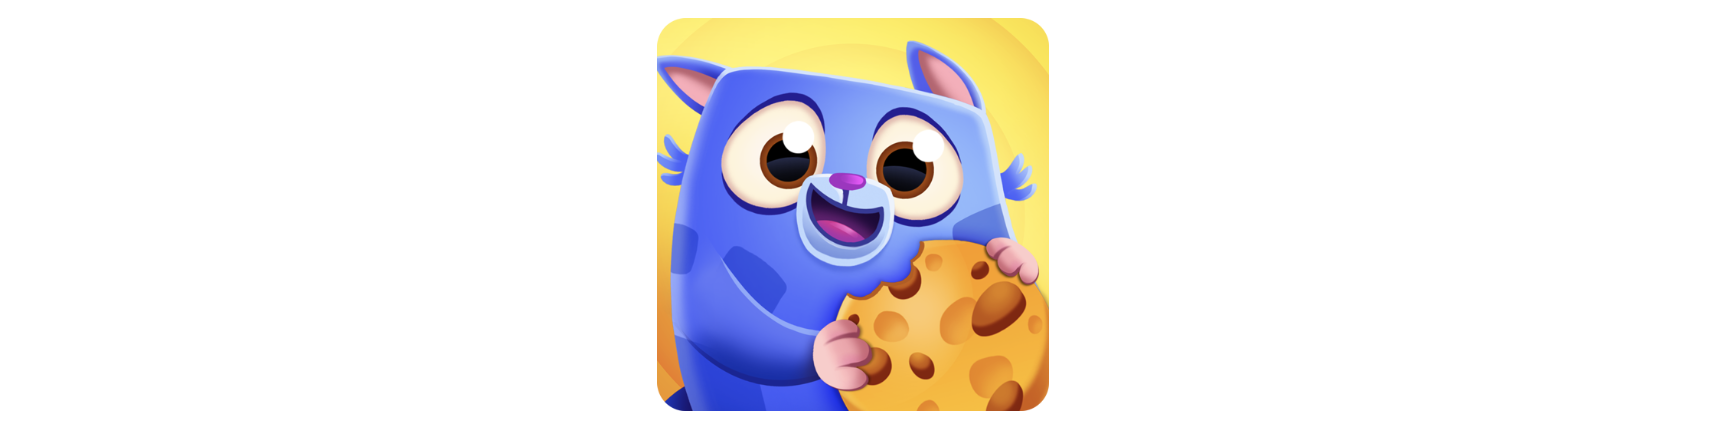

### The data is about an A/B test with a mobile game, Cookie Cats. 

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.width', 500)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('cookie_cats.csv')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.shape

(90189, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
df['retention_1'] = df['retention_1'].astype(int)
df['retention_7'] = df['retention_7'].astype(int)

In [7]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [8]:
df.describe([.99, .95, .9, .75, .5, .25, .1, .05, .01])

,userid,sum_gamerounds,retention_1,retention_7
count,90189.0000,90189.0000,90189.0000,90189.0000
mean,4998412.2345,51.8725,0.4452,0.1861
std,2883285.6077,195.0509,0.4970,0.3892
min,116.0000,0.0000,0.0000,0.0000
1%,100928.9200,0.0000,0.0000,0.0000
5%,502935.0000,1.0000,0.0000,0.0000
10%,992512.8000,1.0000,0.0000,0.0000
25%,2512230.0000,5.0000,0.0000,0.0000
50%,4995815.0000,16.0000,0.0000,0.0000
75%,7496452.0000,51.0000,1.0000,0.0000


### FIRST INFERENCES

- There is no missing value in dataset.

- It is clear that there are outliers in the sum_gamerounds column.

- The percentage of those who came back to the game 1 day after installing the game is 44.521%.

- The percentage of those who came back to the game 1 day after installing the game is 18.606%.

## The Number Of Game Rounds Played Analysis

In [9]:
print(f"The number of people who installed the game but never played it : {df[df['sum_gamerounds'] == 0].shape[0]}")

The number of people who installed the game but never played it : 3994


In [10]:
gate_30 = df[df['version'] == 'gate_30'].groupby('sum_gamerounds')['userid'].count()
gate_40 = df[df['version'] == 'gate_40'].groupby('sum_gamerounds')['userid'].count()

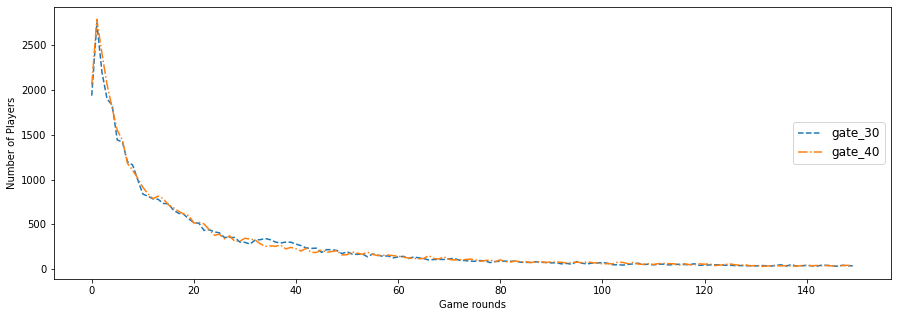

In [11]:
plt.figure(figsize=(15,5))

ax = gate_30[:150].plot(label='gate_30', linestyle='--')
ax = gate_40[:150].plot(label='gate_40', linestyle='-.')
ax.set_ylabel("Number of Players")
ax.set_xlabel('Game rounds')
plt.legend(loc=5, fontsize=12)
plt.show()

In [12]:
df.groupby('version')['sum_gamerounds'].agg(['median', 'mean', 'std', 'max'])

,median,mean,std,max
version,,,,
gate_30,17.0000,52.4563,256.7164,49854
gate_40,16.0000,51.2988,103.2944,2640


- It is clear that the distribution is highly right-skewed. Most players played the game for fewer than 20 rounds during the first 1 week after installation.
- Also the control and test groups have similar distributions.  
- Hypothesis testing should be applied to determine whether there is a statistically significant difference.

## Retention 1 Analysis

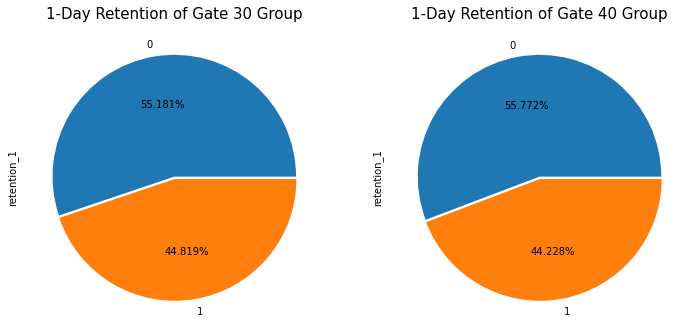

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
explode = (0, 0.02)
df[df['version'] == 'gate_30'].retention_1.value_counts().plot(kind='pie', explode=explode, autopct='%1.3f%%')
plt.title('1-Day Retention of Gate 30 Group', fontsize=15)

plt.subplot(1, 2, 2)
df[df['version'] == 'gate_40'].retention_1.value_counts().plot(kind='pie', explode=explode, autopct='%1.3f%%')
plt.title('1-Day Retention of Gate 40 Group', fontsize=15)
plt.show()


## Retention 7 Analysis

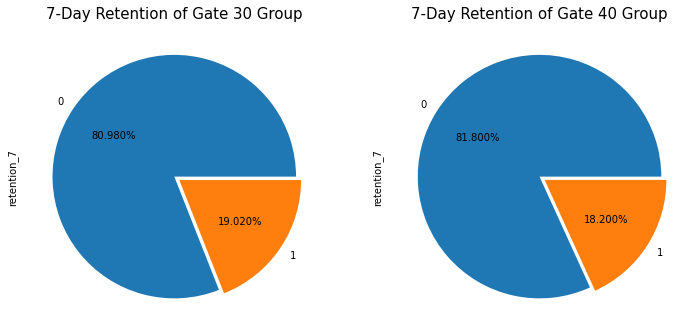

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
explode = (0, 0.05)
df[df['version'] == 'gate_30'].retention_7.value_counts().plot(kind='pie', explode=explode, autopct='%1.3f%%')
plt.title('7-Day Retention of Gate 30 Group', fontsize=15)

plt.subplot(1, 2, 2)
df[df['version'] == 'gate_40'].retention_7.value_counts().plot(kind='pie', explode=explode, autopct='%1.3f%%')
plt.title('7-Day Retention of Gate 40 Group', fontsize=15)
plt.show()

- There is a slight decrease in the rate of continuing the game after moved to gate 40.

## Potential Problems / Outlier Analysis 

 An outlier is a point for which yi is far from the value predicted by the model. Outliers can arise for a variety of reasons, such as incorrect recording of observation during data collection.

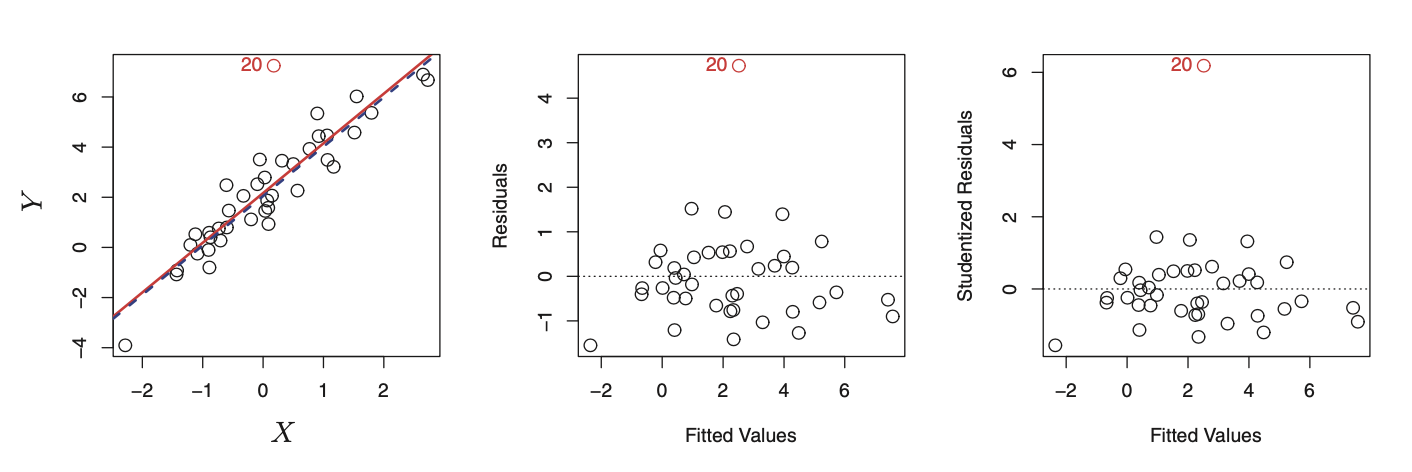

- The red point (observation 20) in the left-hand panel of Figure illustrates a typical outlier.

   *An Introduction to Statistical Learning (Gareth James • Daniela Witten • Trevor Hastie Robert Tibshirani) 


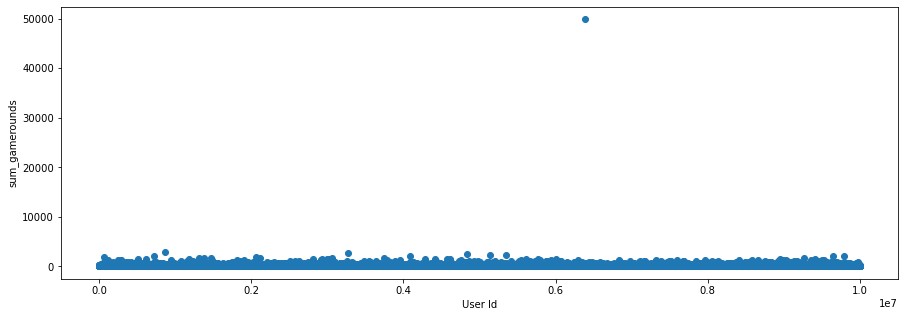

In [15]:
fig, ax = plt.subplots(figsize =(15, 5))
ax.scatter(df['userid'], df['sum_gamerounds'])
ax.set_ylabel("sum_gamerounds")
ax.set_xlabel('User Id')
plt.show()

In [16]:
df[['sum_gamerounds']].describe([.1, .25, .5, .75, .95, .99]).T

,count,mean,std,min,10%,25%,50%,75%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,1.0000,5.0000,16.0000,51.0000,221.0000,493.0000,49854.0000


In [17]:
df[df['sum_gamerounds'] == 49854]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,0,1


**It is clear that the observation 49854 is an outlier.**

In [18]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [19]:
replace_with_thresholds(df, 'sum_gamerounds')

**Outliers are slightly threshed so as not to break the structure of the dataset.**

In [20]:
df['sum_gamerounds'].value_counts(bins=7)

(-1.2329999999999999, 176.071]    83879
(176.071, 352.143]                 4376
(352.143, 528.214]                 1193
(528.214, 704.286]                  418
(704.286, 880.357]                  163
(1056.429, 1232.5]                   97
(880.357, 1056.429]                  63
Name: sum_gamerounds, dtype: int64

# AB Testing


In [21]:
df['version'] = np.where(df.version == 'gate_30', 'A', 'B')

## Sumgamerounds Test

1. Establish Hypotheses

2. Assumption Check
 - 1. Normality Assumption
 - 2. Variance Homogeneity
3. Implementation of the Hypothesis
 - 1. Apply Independent two-sample t-test (parametric test) if assumptions are satisfied
 - 2. Apply Mannwhitneyu test if assumptions are not satisfied (non-parametric test)
4. Interpret results based on p-value  
**Note**:
 - If normality is not satisfied, non-parametric test is applied directly, if variance homogeneity is not satisfied, an argument is entered for parametric test.

     H0: M1 = M2  
  *There is no significant statistical difference between the control and test groups for the number of game rounds played by the player during the first week after installation.*
  
  
     H1: M1 != M2  
  *There is  significant statistical difference between the control and test groups for the number of game rounds played by the player during the first week after installation.* 


###  Normality Assumption

    H0: Distribution is Normal! - False
    H1: Distribution is not Normal! - True

In [22]:
test_stat, pvalue = shapiro(df.loc[df['version'] == 'A', 'sum_gamerounds'])
print('Test Stat = %.5f, p-value = %.5f' % (test_stat, pvalue))

Test Stat = 0.51041, p-value = 0.00000


   **We reject the null hypothesis**

In [23]:
test_stat, pvalue = shapiro(df.loc[df['version'] == 'B', 'sum_gamerounds'])
print('Test Stat = %.5f, p-value = %.5f' % (test_stat, pvalue))

Test Stat = 0.50438, p-value = 0.00000


**We reject the null hypothesis**

- Nonparametric test should be applied as normality is not satisfied

In [24]:
test_stat, pvalue = mannwhitneyu(df.loc[df['version'] == 'A', 'sum_gamerounds'],
                                 df.loc[df['version'] == 'B', 'sum_gamerounds'])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 1024331275.0000, p-value = 0.0502


**Since the assumption of normality is not satisfied, I applied a nonparametric test.  
 According to the p value, the h0 hypothesis cannot be rejected. That is, there is no significant statistical difference between the number of game rounds between the two groups.**

## Retention 1 

In [25]:
gate_30_yes_count = df.loc[df['version'] == 'A', 'retention_1'].sum()
gate_40_yes_count = df.loc[df['version'] == 'B', 'retention_1'].sum()

test_stat, pvalue = proportions_ztest(count=[gate_30_yes_count, gate_40_yes_count],
                                      nobs=[df.loc[df['version'] == 'A', 'retention_1'].shape[0],
                                            df.loc[df['version'] == 'B', 'retention_1'].shape[0]])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 1.7841, p-value = 0.0744


**Fail to reject the null hypothesis . There is no significant statistical difference between the groups.**

##  Retention 7 

In [26]:
gate_30_yes_count = df.loc[df['version'] == 'A', 'retention_7'].sum()
gate_40_yes_count = df.loc[df['version'] == 'B', 'retention_7'].sum()

test_stat, pvalue = proportions_ztest(count=[gate_30_yes_count, gate_40_yes_count],
                                      nobs=[df.loc[df['version'] == 'A', 'retention_7'].shape[0],
                                            df.loc[df['version'] == 'B', 'retention_7'].shape[0]])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 3.1644, p-value = 0.0016


**Reject the null hypothesis . There is significant statistical difference between gate30 and gate40.**

# Conclusion

- 3994 people out of 90189 people who installed the game never played the game. The company needs to figure out why these customers aren't playing.  
- Maybe they don't have enough time. They may also not like the game interface.

- There is a statistical difference between gate 30 and gate 40 for retention 7 days.
- We can say that the gate30 group is statistically more likely to play the game one week after installing the game.
- There is no statistically significant difference for sumgamerounds and retention 1.
- Finally, The company should keep using the old version. 